In [21]:
from methods.config import *
import numpy as np; rnd=np.random.default_rng()
import matplotlib.pyplot as plt; import matplotlib as mpl
import methods.util as util
import pickle
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats
import methods.shared as shared
# import methods.sim_mbarcodes as sim

# from importlib import reload
# reload(util);
# reload(shared);
# from matplotlib.backends.backend_pdf import PdfPages

This script assigns barcodes to plates (for Cohort 1 / Experiment 1), or to smaller input pools (Cohort 2 / Experiment 2 and in vitro)

In [22]:
## focus on barcodes reaching greater than 10^-5 frequency in at least one library
# first 11 rows are input libraires
relevant_barcodes = ((shared.read_array[11:] > 0).sum(axis=0) > 1) & ((shared.freq_array[11:] > 1e-5).sum(axis=0) > 0)
print(f"Number of lineages to be considered: {relevant_barcodes.sum()}")

Number of lineages to be considered: 59182


Number of P1 barcodes: 28093
Number of P2 barcodes: 24234
Overlap between P1 and P2 =? 0: 0
Number of ambiguous barcodes:  6855


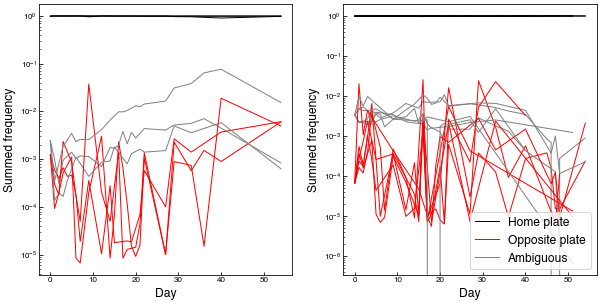

In [23]:
# P1 and P2 assignment
P1_index, P2_index = 0, 1

P1_freqs = shared.freq_array[P1_index]
P1_early_timepoint_rows = [P1_index] + [shared.vivo_row_ids[('E1', mouse, day)] for mouse in range(6, 11) for day in range(1, 5) if ('E1', mouse, day) in shared.vivo_row_ids]
P1_early_reads = shared.read_array[P1_early_timepoint_rows]
P1_early_freqs = shared.freq_array[P1_early_timepoint_rows]

P2_freqs = shared.freq_array[P2_index]
P2_early_timepoint_rows = [P2_index] + [shared.vivo_row_ids[('E1', mouse, day)] for mouse in range(1,6) for day in range(1, 5) if ('E1', mouse, day) in shared.vivo_row_ids]
P2_early_reads = shared.read_array[P2_early_timepoint_rows]
P2_early_freqs = shared.freq_array[P2_early_timepoint_rows]

P1_twice_measured = (P1_early_reads > 0).sum(axis=0) > 1
P2_twice_measured = (P2_early_reads > 0).sum(axis=0) > 1

P1_day14_rows = [shared.vivo_row_ids[('E1', mouse, day)] for mouse in range(6, 10) for day in range(10, 15) if ('E1', mouse, day) in shared.vivo_row_ids]
P2_day14_rows = [shared.vivo_row_ids[('E1', mouse, day)] for mouse in range(1, 6) for day in range(10, 15) if ('E1', mouse, day) in shared.vivo_row_ids]
P1_day14_reads = shared.read_array[P1_day14_rows]
P1_day14_freqs = shared.freq_array[P1_day14_rows]
P2_day14_reads = shared.read_array[P2_day14_rows]
P2_day14_freqs = shared.freq_array[P2_day14_rows]

with np.errstate(divide='ignore'):
    P1_freqs0, P2_freqs0 = shared.freq_array[P1_index] + 1e-12, shared.freq_array[P2_index] + 1e-12 #avoid np.errstate when taking ratio
    P1_bool = P1_twice_measured & ((~P2_twice_measured) | (np.log10(P1_freqs0/P2_freqs0) > 1)) & relevant_barcodes 
    P2_bool = P2_twice_measured & ((~P1_twice_measured) | (np.log10(P1_freqs0/P2_freqs0) < -1)) & relevant_barcodes 
   
    E1_ambiguous_bool = (~P1_bool) & (~P2_bool) & relevant_barcodes

# Plot cumualtive frequencies of the partitions, in mice that were *not* cross-housed
fig, axs = plt.subplots(1, 2, figsize=(10,5))
ax = axs[0]
for mice, ax, home_bool, opposite_bool, color in zip([range(1, 4), range(8,14)],
                                          [axs[0], axs[1]], 
                                          [P2_bool, P1_bool],
                                          [P1_bool, P2_bool], 
                                          ['red', 'blue']):
    ax.set_xlabel('Day', fontsize=12)
    ax.set_ylabel('Summed frequency', fontsize=12)

    for m, mouse in enumerate(mice):
        home_label, opp_label, ambig_label = '', '', ''
        if m == 0:
            home_label = 'Home plate'
            opp_label = 'Opposite plate'
            ambig_label = 'Ambiguous'
        
        mouse_days, mouse_rows, cec = shared.mouse_meta['E1'][mouse]

        mouse_freqs = shared.freq_array[mouse_rows][:, home_bool].sum(axis=1)
        ax.plot(mouse_days, mouse_freqs, color='black', label=home_label, lw=1)

        mouse_freqs = shared.freq_array[mouse_rows][:, opposite_bool].sum(axis=1)
        ax.plot(mouse_days, mouse_freqs, color='red', label=opp_label, lw=1)

        mouse_freqs = shared.freq_array[mouse_rows][:, E1_ambiguous_bool].sum(axis=1)
        ax.plot(mouse_days, mouse_freqs, color='grey', label=ambig_label, lw=1)
        ax.set_yscale('log')
ax.legend(fontsize=12)

print('Number of P1 barcodes:', P1_bool.sum())
print('Number of P2 barcodes:', P2_bool.sum())
print('Overlap between P1 and P2 =? 0:', (P1_bool & P2_bool).sum())
print('Number of ambiguous barcodes: ', np.sum(E1_ambiguous_bool))

In [40]:
# Cohort 2 / experiment 2 pool ids
set1_idx, set2_idx, set3_idx, set4_idx, set5_indices = 2, 3, 4, 5, [6, 10]

# set 1 and set 2 are two high diversity pools of ~10k barcodes
set1_all_rows = [set1_idx] \
                + [shared.vivo_row_ids[('E2', mouse, day)] for mouse in [1,6] for day in range(1, 5) if ('E2', mouse, day) in shared.vivo_row_ids]  \
                + [shared.vivo_row_ids[('E2', 11, day)]for day in range(15, 19) if ('E2', 11, day) in shared.vivo_row_ids]
set2_all_rows = [set2_idx] \
                + [shared.vivo_row_ids[('E2', mouse, day)] for mouse in [2,7] for day in range(1, 5) if ('E2', mouse, day) in shared.vivo_row_ids] \
                + [shared.vivo_row_ids[('E2', 12, day)]for day in range(15, 19) if ('E2', 12, day) in shared.vivo_row_ids]
# set1_freqs0, set2_freqs0 = shared.freq_array[set1_idx] + 1e-12, shared.freq_array[set2_idx] + 1e-12
set1_bool = (P1_bool | E1_ambiguous_bool) & ( (shared.read_array[set1_all_rows] > 0).sum(axis=0) > 1 ) & relevant_barcodes #* (shared.freq_array[set1_idx] > shared.freq_array[set2_idx])
set2_bool = (P1_bool | E1_ambiguous_bool) & ( (shared.read_array[set2_all_rows] > 0).sum(axis=0) > 1 ) & relevant_barcodes #* (shared.freq_array[set2_idx] > shared.freq_array[set1_idx])

# set 5 is the low diversity pool of ~100 barcodes
set5_bool = ((shared.freq_array[set5_indices] > 1e-3 ).sum(axis=0) == 2) & relevant_barcodes #measured in both day0 libraries

# set 3 and set 4 are two high diversity pools of ~7000 barcodes, but immediately cross-housed...
set3_indices, set4_indices = [4,8], [5, 9]
set3_freqs0, set4_freqs0 = shared.freq_array[set3_idx] + 1e-12, shared.freq_array[set4_idx] + 1e-12

set3_bool = (P2_bool | E1_ambiguous_bool) * (np.log10(set3_freqs0/set4_freqs0) > 1) * (~set5_bool) & relevant_barcodes 
set4_bool = (P2_bool | E1_ambiguous_bool) * (np.log10(set3_freqs0/set4_freqs0) < -1) * (~set5_bool) & relevant_barcodes

E2_ambiguous_bool = (~set1_bool) * (~set2_bool) * (~set3_bool) * (~set4_bool) * (~set5_bool) & relevant_barcodes

set1 barcodes: 12700, set2 barcodes: 11579, overlapping: 28
N_barcodes in Set 5: 109; overlapping with Plate 1: 86; with Plate 2: 0; with ambiguous: 23
set3 barcodes: 6636, set4 barcodes: 7728, overlapping: 0
Overlap between set1 & set2: 28
Overlap between set1 & set3: 2
Overlap between set1 & set4: 0
Overlap between set1 & set5: 60
Overlap between set2 & set3: 2
Overlap between set2 & set4: 1
Overlap between set2 & set5: 52
Overlap between set3 & set4: 0
Overlap between set3 & set5: 0
Overlap between set4 & set5: 0


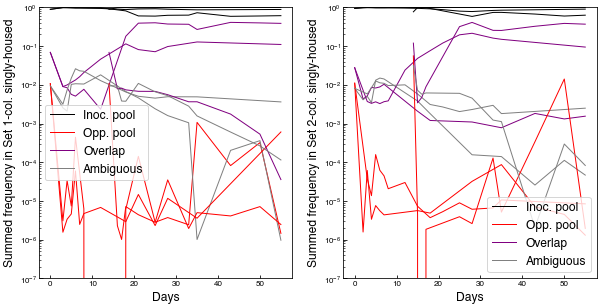

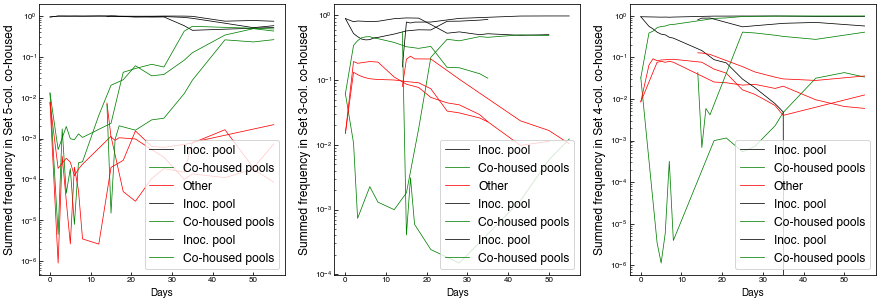

In [41]:

### Above leaves some ambiguous barcodes, which grow large in individual mice and then transfer to others
### Disambiguate them here...
def calc_interp_freq(t1, f1, t2, f2, intermediate_time):
    return np.exp((np.log(f2) - np.log(f1)) * (intermediate_time - t1)/(t2-t1) + np.log(f1))

E2_rows = [row for mouse in range(1,16) for row in shared.mouse_meta['E2'][mouse][1][1:]]
barcode_bool_dict = {1:set1_bool, 2:set2_bool, 3:set3_bool, 4:set4_bool, 5:set5_bool,
                     6:set1_bool, 7:set2_bool, 8:set3_bool, 9:set4_bool, 10:set5_bool,
                     11:set1_bool, 12:set2_bool, 13:set3_bool, 14:set4_bool, 15:set5_bool,}

freq_arrays = np.einsum('ij, i->ij', shared.read_array[E2_rows], shared.read_array[E2_rows].sum(axis=1)**-1.)
for barcode in np.arange(E2_ambiguous_bool.shape[0])[E2_ambiguous_bool]:
    if np.max(freq_arrays[:, barcode]) > 1e-2:
        # fig, axs = plt.subplots(1, 3, figsize=(6,2))
        for m, mice in enumerate([[3,4,5], [8,9,10], [13,14,15]]):
            # ax = axs[m]
            time_reached_1percent = {}
            for mouse, color in zip(mice, ['red', 'green', 'blue', 'purple', 'orange']):
                mouse_days, mouse_rows, cec_id = shared.mouse_meta['E2'][mouse]

                lineage_freqs = shared.freq_array[mouse_rows][:, barcode]
                # ax.plot(np.array(mouse_days)+1, lineage_freqs, color=color)

                z = np.where(lineage_freqs > 0.01)[0]
                if len(z) > 0:
                    time_reached_1percent[mouse] = [mouse_days[z[0]], lineage_freqs[z[0]]]

            # ax.set_yscale('log')
            # ax.set_ylim(10**-6, 1)
            # ax.set_xscale('log')
            # ax.axhline(10**-2, color='black', linestyle='dashed')

            if len(time_reached_1percent) == 0:
                continue

            flag = True
            if len(time_reached_1percent) == 1: #only reached 1 percent in 1 mouse
                originating_mouse = list(time_reached_1percent.keys())[0]
                # ax.set_title(originating_mouse)
            else:
                originating_mouse, [putative_time, freq] = sorted(time_reached_1percent.items(), key=lambda x:x[1])[0]
                for mouse in mice:
                    if mouse != originating_mouse:
                        mouse_days, mouse_rows, _ = shared.mouse_meta['E2'][mouse]
                        lineage_freqs = shared.freq_array[mouse_rows, barcode]
                        if putative_time in mouse_days:
                            t_idx = np.where(mouse_days == putative_time)[0][0]
                            if lineage_freqs[t_idx] / freq > 1e-1:
                                flag = False
                        else: 
                            nearest_z1, nearest_z2 = np.where( mouse_days < putative_time )[0][-1], np.where( mouse_days > putative_time )[0][-1]
                            nearest_t1, nearest_t2 = mouse_days[nearest_z1], mouse_days[nearest_z2]
                            interp_freq = calc_interp_freq(nearest_t1, lineage_freqs[nearest_z1] + 1e-4, nearest_t2, lineage_freqs[nearest_z2] + 1e-4, putative_time)
                            if interp_freq / freq > 1e-1:
                                flag = False
            if flag:
                # ax.set_title(originating_mouse)
                E2_ambiguous_bool[barcode] = False
                barcode_bool_dict[ originating_mouse ][barcode] = True
        


fig, axs = plt.subplots(1, 2, figsize=(10,5))
for r, (mice, set_bool, alt_bool, set_label) in enumerate(zip([[1,6,11], [2,7,12]], (set1_bool, set2_bool), (set2_bool, set1_bool), ("Set 1", "Set 2"))):
    ax = axs[r]
    for m, mouse in enumerate(mice):
        home_label, opp_label, overlap_label, ambig_label = 'Inoc. pool', 'Opp. pool', 'Overlap', 'Ambiguous'
        if m > 0:
            home_label, opp_label, overlap_label, ambig_label = '', '', '', ''
        mouse_days, mouse_rows, cec = shared.mouse_meta['E2'][mouse]
        # mouse_P1_freqs = shared.freq_array[mouse_rows][:, P1_bool].sum(axis=1)
        # ax.plot(mouse_days, mouse_P1_freqs, color='black', lw=2)

        mouse_freqs = shared.freq_array[mouse_rows][:, set_bool & (~alt_bool)].sum(axis=1)
        ax.plot(mouse_days, mouse_freqs, label=home_label, color='black', lw=1)

        mouse_alt_freqs = shared.freq_array[mouse_rows][:, (~set_bool) & alt_bool].sum(axis=1)
        ax.plot(mouse_days, mouse_alt_freqs, color='red', label=opp_label,  lw=1)

        mouse_alt_freqs = shared.freq_array[mouse_rows][:, set_bool & alt_bool].sum(axis=1)
        ax.plot(mouse_days, mouse_alt_freqs, color='purple', label=overlap_label, lw=1)

        mouse_alt_freqs = shared.freq_array[mouse_rows][:, E2_ambiguous_bool].sum(axis=1)
        ax.plot(mouse_days, mouse_alt_freqs, color='grey', lw=1, label=ambig_label)
    ax.set_ylim(1e-7, 1.05)
    ax.set_yscale('log')
    ax.legend(fontsize=12)
    ax.set_xlabel('Days', fontsize=12)
    ax.set_ylabel(f'Summed frequency in {set_label}-col. singly-housed', fontsize=12)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for r, (mice, set_bool, alt_bool, set_label) in enumerate(zip( [[5, 10, 15], [3, 8, 13], [4, 9, 14]], 
                                                              (set5_bool, set3_bool, set4_bool),
                                                              (set3_bool | set4_bool, set4_bool | set5_bool, set3_bool | set5_bool),
                                                              ("Set 5", "Set 3", "Set 4"))):
    ax = axs[r]
    for m, mouse in enumerate(mice):
        home_label = 'Inoc. pool'
        opp_label = 'Co-housed pools'
        other_label = 'Other'
        if m > 0:
            set5_label, set34_label, other_label = '', '', ''

        mouse_days, mouse_rows, cec = shared.mouse_meta['E2'][mouse]
        mouse_freqs = shared.freq_array[mouse_rows][:, set_bool].sum(axis=1)
        mouse_ambig_freqs = shared.freq_array[mouse_rows][:, E2_ambiguous_bool].sum(axis=1)
        mouse_set34_freqs =  shared.freq_array[mouse_rows][:, alt_bool].sum(axis=1)

        ax.plot(mouse_days, mouse_freqs, color='black', label=home_label)
        ax.plot(mouse_days, mouse_set34_freqs, color='green', label=opp_label)
        ax.plot(mouse_days, mouse_ambig_freqs, color='red', label = other_label)
    ax.legend(fontsize=12)
    ax.set_yscale('log')
    ax.set_ylabel(f'Summed frequency in {set_label}-col. co-housed', fontsize=12)
    ax.set_xlabel(f'Days')

print( f'set1 barcodes: {set1_bool.sum()}, set2 barcodes: {set2_bool.sum()}, overlapping: {(set1_bool & set2_bool).sum()}')
print( f'N_barcodes in Set 5: {set5_bool.sum()}; overlapping with Plate 1: {(set5_bool * P1_bool).sum()}; with Plate 2: {(set5_bool * P2_bool).sum()}; with ambiguous: {(set5_bool & ~P1_bool & ~P2_bool).sum()}')
print( f'set3 barcodes: {set3_bool.sum()}, set4 barcodes: {set4_bool.sum()}, overlapping: {(set3_bool & set4_bool).sum()}')

for i, (namex, setx) in list(enumerate(zip(["set1", "set2", "set3", "set4", "set5"], [set1_bool, set2_bool, set3_bool, set4_bool, set5_bool])))[:-1]:
    for namey, sety in list(zip(["set1", "set2", "set3", "set4", "set5"], [set1_bool, set2_bool, set3_bool, set4_bool, set5_bool]))[i+1:]:
        print(f'Overlap between {namex} & {namey}:', (setx & sety).sum())


In [44]:
## assign additional barcodes to sets 3 and 4, for plotting purposes
## but this conditioning spoils analysis of transmission 

m3_rows = shared.mouse_meta['E2'][3][1]
m4_rows = shared.mouse_meta['E2'][4][1]
m5_rows = shared.mouse_meta['E2'][5][1]

m3_freqs = shared.freq_array[m3_rows]
m4_freqs = shared.freq_array[m4_rows]
m5_freqs = shared.freq_array[m5_rows]

likely_set3 = ((m3_freqs > 0).sum(axis=0) > 0) & ( (m4_freqs > 0).sum(axis=0) == 0 ) & ( (m5_freqs > 0).sum(axis=0) == 0 ) #& E2_ambiguous_bool
likely_set4 =((m4_freqs > 0).sum(axis=0) > 0) & ( (m3_freqs > 0).sum(axis=0) == 0) & ( (m5_freqs > 0).sum(axis=0) == 0) #& E2_ambiguous_bool

# ###
m3_rows = shared.mouse_meta['E2'][13][1]
m4_rows = shared.mouse_meta['E2'][14][1]
m5_rows = shared.mouse_meta['E2'][15][1]

m3_freqs = shared.freq_array[m3_rows]
m4_freqs = shared.freq_array[m4_rows]
m5_freqs = shared.freq_array[m5_rows]

likely_set3 += ((m3_freqs > 0).sum(axis=0) > 0) & ( (m4_freqs > 0).sum(axis=0) == 0 ) & ( (m5_freqs > 0).sum(axis=0) == 0 ) #& E2_ambiguous_bool
likely_set4 += ((m4_freqs > 0).sum(axis=0) > 0) & ( (m3_freqs > 0).sum(axis=0) == 0) & ( (m5_freqs > 0).sum(axis=0) == 0) #& E2_ambiguous_bool

# E2_ambiguous_bool[likely_set4] = False
# set4_bool[likely_set4] = True

set3_bool = (likely_set3 > 0) & relevant_barcodes
set4_bool = (likely_set4 > 0) & relevant_barcodes
# E2_ambiguous_bool = (~set1_bool) * (~set2_bool) * (~set3_bool) * (~set4_bool) * (~set5_bool) & relevant_barcodes

set3_bool_plotting = (likely_set3 > 0) & relevant_barcodes
set4_bool_plotting = (likely_set4 > 0) & relevant_barcodes
E2_ambiguous_bool_plotting = (~set1_bool) * (~set2_bool) * (~set3_bool_plotting) * (~set4_bool_plotting) * (~set5_bool) & relevant_barcodes

In [42]:
# in vitro
with open(f'{data_dir}/pickled/vitro_array.pkl', 'rb') as f:
    vitro_array = pickle.load(f)
    vitro_freqs = vitro_array / np.sum(vitro_array, axis=1).reshape(-1,1)

with open(f'{data_dir}/pickled/vitro_meta.pkl', 'rb') as f:
    vitro_meta = pickle.load(f)

with open(f'{data_dir}/pickled/vitro_col_map.pkl', 'rb') as f:
    vitro_col_map = pickle.load(f)

vitro_inoc_assignments = {}
for input_library in ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']:  
    input_freqs = vitro_freqs[vitro_col_map[('vitro', input_library,0)]]
    input_bool = input_freqs > 1e-6
    input_indices = np.arange(input_bool.shape[0])[input_bool]

    inoc_freqs = [input_freqs]
    for medium, wells in shared.medium_to_well_map.items():
        for well, inoc in wells:
            if inoc == input_library:
                passages, rows = vitro_meta[well]
                inoc_freqs.extend(vitro_freqs[rows[1:]])
                # inoc_freqs.append(vitro_freqs[rows[2]])

    inoc_freqs = np.array(inoc_freqs)
    inoc_bool = (inoc_freqs[0] > 1e-6) | ( (inoc_freqs[1:] > 1e-3).sum(axis=0) > 0 )
    # inoc_bool = ( (inoc_freqs[1:] > 1e-2).sum(axis=0) > 0 )

    inoc_bool_loose = ( (inoc_freqs[1:] > 1e-5).sum(axis=0) > 0 )
    # inoc_bool = ( (inoc_freqs[1:] > 1e-2).sum(axis=0) > 0 )

    inoc_indices = np.arange(inoc_bool.shape[0])[inoc_bool]
    vitro_inoc_assignments[input_library] = [inoc_indices, inoc_bool]

all_rows = [vitro_col_map[('vitro', v, 0)] for v in ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']]
row_names = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']
for medium, wells in shared.medium_to_well_map.items():
    for well, inoc in wells:
        passages, rows = vitro_meta[well]
        all_rows.extend(rows[1:])
        row_names.extend([(f'{well}_{passage}', inoc) for passage in passages[1:]])
all_rows = np.array(all_rows)
row_names = np.array(row_names)
sorted_freqs = vitro_freqs[all_rows]


pool_indices = []
for inoc_1 in ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
    for inoc_2 in ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
        if inoc_1 == inoc_2:
            continue
        inoc_1_indices, inoc_1_bool = vitro_inoc_assignments[inoc_1]
        inoc_2_indices, inoc_2_bool = vitro_inoc_assignments[inoc_2]

        pool_indices.extend(list(np.arange(inoc_1_bool.shape[0])[(inoc_1_bool & inoc_2_bool)]))
        # overlap = (inoc_1_bool & inoc_2_loose) | (inoc_2_bool & inoc_1_loose)


        # overlap = list(set(inoc_1_indices) & set(inoc_2_indices))
        # overlap_freqs = sorted_freqs[:, overlap]
        # for barcode_freqs in overlap_freqs.transpose():
        #     overlap_bool = barcode_freqs > 1e-2
        #     print(inoc_1, inoc_2, row_names[overlap_bool])


        # new_inoc_1_indices = [x for x in inoc_1_indices if x not in overlap]
        # new_inoc_2_indices = [x for x in inoc_2_indices if x not in overlap]

        # vitro_inoc_assignments[inoc_1] = (new_inoc_1_indices, inoc_1_bool)
        # vitro_inoc_assignments[inoc_2] = (new_inoc_2_indices, inoc_2_bool)

        print(f'{inoc_1}:',  inoc_1_bool.sum(), f'{inoc_2}:',inoc_2_bool.sum(), 'Overlap:', (inoc_1_bool & inoc_2_bool).sum())


pool_indices = list(set(pool_indices))
print(len(pool_indices))

for index in pool_indices:
    inoc_x = {inoc:[] for inoc in ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']}
    for medium, wells in shared.medium_to_well_map.items():
        for well, inoc in wells:
            passages, rows = vitro_meta[well]
            freqs = vitro_freqs[rows[1:]][:,index]
            # inoc_x[inoc].extend(np.sum(freqs, axis=1))
            inoc_x[inoc].extend(freqs)
    above_1e_3 = sorted([(inoc, np.sum(np.array(x)>1e-3)) for inoc, x in inoc_x.items()], reverse=True, key=lambda x:x[1])

    for inoc, n_above in above_1e_3[1:]:
        bool_n_above = np.where(vitro_inoc_assignments[inoc][0] != index)[0]
        vitro_inoc_assignments[inoc][0] = vitro_inoc_assignments[inoc][0][bool_n_above]
        vitro_inoc_assignments[inoc][1][index] = False

    # fig, ax = plt.subplots()
    # for inoc, x in inoc_x.items():
    #     ax.plot(x)
    #     ax.set_yscale('log')


In [43]:
pool_indices = []
for inoc_1 in ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
    for inoc_2 in ['V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
        if inoc_1 == inoc_2:
            continue
        inoc_1_indices, inoc_1_bool = vitro_inoc_assignments[inoc_1]
        inoc_2_indices, inoc_2_bool = vitro_inoc_assignments[inoc_2]

        # pool_indices.extend(list(np.arange(inoc_1_bool.shape[0])[(inoc_1_bool & inoc_2_bool)]))
        # overlap = (inoc_1_bool & inoc_2_loose) | (inoc_2_bool & inoc_1_loose)

        print(f'{inoc_1}:',  inoc_1_bool.sum(), f'{inoc_2}:',inoc_2_bool.sum(), 'Overlap:', (inoc_1_bool & inoc_2_bool).sum())


In [45]:
# Save barcode assignments

indices = np.arange(len(shared.barcodes))
P1_indices = indices[P1_bool]
P2_indices = indices[P2_bool]
E1_ambiguous_indices = indices[E1_ambiguous_bool]

set1_indices = indices[set1_bool]
set2_indices = indices[set2_bool]
set3_indices = indices[set3_bool]
set4_indices = indices[set4_bool]
set5_indices = indices[set5_bool]
E2_ambiguous_indices = indices[E2_ambiguous_bool]

set3_indices_plotting = indices[set3_bool_plotting]
set4_indices_plotting = indices[set4_bool_plotting]
E2_ambiguous_indices_plotting = indices[E2_ambiguous_bool_plotting]

barcode_pool_assignments = {
    'P1': (P1_indices, P1_bool),
    'P2': (P2_indices, P2_bool),
    'E1_ambiguous': (E1_ambiguous_indices, E1_ambiguous_bool),
    'set1': (set1_indices, set1_bool),
    'set2': (set2_indices, set2_bool),
    'set3': (set3_indices, set3_bool),
    'set4': (set4_indices, set4_bool),
    'set5': (set5_indices, set5_bool),
    'E2_ambiguous': (E2_ambiguous_indices, E2_ambiguous_bool),
    'set3_plotting': (set3_indices_plotting, set3_bool_plotting),
    'set4_plotting': (set4_indices_plotting, set4_bool_plotting),
    'E2_ambiguous_plotting': (E2_ambiguous_indices_plotting, E2_ambiguous_bool_plotting),
} | vitro_inoc_assignments
 
print('Total relevant barcodes:', relevant_barcodes.sum())
print('Total E1 indices:', len(P1_indices) + len(P2_indices) + len(E1_ambiguous_indices))
print('Total E2 indices:', (set1_bool | set2_bool | set3_bool | set4_bool | set5_bool | E2_ambiguous_bool).sum() )
print('\n')
print('Size of each index set...')
for set_name, (set_indices, set_bool) in barcode_pool_assignments.items():
    print(f'{set_name}:', len(set_indices))

print('\n')
print('Overlap between indices...')
set_items = list(barcode_pool_assignments.items())
for i, (setx_name, (setx_indices, setx_bool)) in enumerate(set_items[:-1]):
    for j in range(i+1, len(set_items)):
        sety_name, (sety_indices, sety_bool) = set_items[j]

        print(f'{setx_name} & {sety_name}:', len(set(setx_indices) & set(sety_indices)))

with open(f'../data/pickled/barcode_pool_assignments.pkl', 'wb') as f:
    pickle.dump(barcode_pool_assignments, f)

Total relevant barcodes: 59182
Total E1 indices: 59182
Total E2 indices: 58997


Size of each index set...
P1: 28093
P2: 24234
E1_ambiguous: 6855
set1: 12700
set2: 11579
set3: 10867
set4: 11727
set5: 109
E2_ambiguous: 20568
set3_plotting: 10867
set4_plotting: 11727


Overlap between indices...
P1 & P2: 0
P1 & E1_ambiguous: 0
P1 & set1: 12276
P1 & set2: 10782
P1 & set3: 335
P1 & set4: 419
P1 & set5: 86
P1 & E2_ambiguous: 5057
P1 & set3_plotting: 335
P1 & set4_plotting: 419
P2 & E1_ambiguous: 0
P2 & set1: 0
P2 & set2: 0
P2 & set3: 8900
P2 & set4: 9949
P2 & set5: 0
P2 & E2_ambiguous: 11339
P2 & set3_plotting: 8900
P2 & set4_plotting: 9949
E1_ambiguous & set1: 424
E1_ambiguous & set2: 797
E1_ambiguous & set3: 1632
E1_ambiguous & set4: 1359
E1_ambiguous & set5: 23
E1_ambiguous & E2_ambiguous: 4172
E1_ambiguous & set3_plotting: 1632
E1_ambiguous & set4_plotting: 1359
set1 & set2: 28
set1 & set3: 203
set1 & set4: 233
set1 & set5: 60
set1 & E2_ambiguous: 0
set1 & set3_plotting: 203
set1 & set4

28093 24234 6855


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_95276/2267038642.py:71: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(0, 1.05)


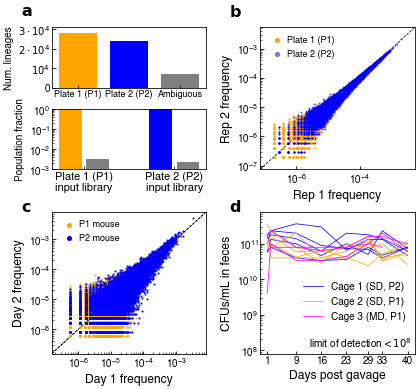

In [48]:
P1_index, P2_index = 0, 1
P1_freqs = shared.freq_array[P1_index]
P2_freqs = shared.freq_array[P2_index]
P1_bool, P2_bool, ambiguous_bool = [shared.barcode_pool_assignments[pool][1] for pool in ['P1', 'P2', 'E1_ambiguous']]
print(P1_bool.sum(), P2_bool.sum(), ambiguous_bool.sum())


## TO DO add day0 technical replicate array file
# day0_rep_array = []
# with open(f'{data_dir}/barcode_seq/all_barcode_reads_trimmed.csv', 'r') as f:
#     header = next(f)
#     for line in f:
#         rep_lst = [int(e) for e in line.split(',')[2:6]]
#         day0_rep_array.append(rep_lst)
# day0_rep_array = np.array(day0_rep_array).transpose()

# day0_freq_array = np.einsum('ij, i->ij', day0_rep_array, day0_rep_array.sum(axis=1)**-1.)
# P1_rep1_freqs, P1_rep2_freqs, P2_rep1_freqs, P2_rep2_freqs = day0_freq_array

with open(f'../data/other/expt1_cfus_per_mL.tsv', 'r') as f:
    next(f)
    header = next(f)
    days = [int(e) for e in header.strip('\n').split('\t')[1:]]

    cfus_mL_dict = {}
    for line in f:
        line_items = line.strip('\n').split('\t')
        mouse = int(line_items[0])

        cfus = [float(e) for e in line_items[1:]]

        cfus_mL_dict[mouse] = cfus
mouse_colors = {i:'blue' for i in range(1, 6)} | {i:'orange' for i in range(6, 11)} | {i:'fuchsia' for i in range(11, 14)}


### Plot technical replicates ~ Fig S1 ###
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

main_fig = plt.figure(figsize=(6.5, 6))
gs = plt.GridSpec(2, 2, figure=main_fig, wspace=0.35, hspace=0.3)

#####################################################
## panel A: barcode pool assignments to Plate 1, 2 ##
#####################################################

inner_grid = gs[0, 0].subgridspec(2, 1, hspace=0.35)
ax = main_fig.add_subplot(inner_grid[0])
ax2 = main_fig.add_subplot(inner_grid[1])
ax.text(-0.2, 1.2, '$\\bf{a}$', fontsize=16, transform=ax.transAxes)


x1_lst = [0, 1, 2]
y1_lst = [P1_bool.sum(), P2_bool.sum(), ambiguous_bool.sum()]
colors = ['Orange', 'Blue', 'Grey']
for x, y, color in zip(x1_lst, y1_lst, colors):
    ax.bar(x, y, facecolor=color, width=0.75)
ax.set_xticks([0, 1, 2])
ax.set_ylim(ax.get_ylim()[0], 31000)
ax.set_yticks([0, 10000, 20000, 30000])
ax.set_yticklabels([0, '$10^4$', '$2 \cdot 10^4$', '$3 \cdot 10^4$'], fontsize=10)
ax.set_xticklabels(['Plate 1 (P1)', 'Plate 2 (P2)', 'Ambiguous'], fontsize=9)
ax.set_ylabel('Num. lineages', fontsize=10)

x2_lst = [-0.15, 0.15, 0.85, 1.15]
y2_lst = [P1_freqs[P1_bool].sum(), P1_freqs[ambiguous_bool].sum(),
          P2_freqs[P2_bool].sum(), P2_freqs[ambiguous_bool].sum()]
colors = ['Orange', 'Grey', 'Blue', 'Grey']
hatches = [None, None, None, None]
for x, y, color, hatch in zip(x2_lst, y2_lst, colors, hatches):
    ax2.bar(x, y, facecolor=color, width=0.25, hatch=hatch)
ax2.set_yscale('log'); ax2.set_ylim(1e-3, 2)
ax2.set_ylim(0, 1.05)
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Plate 1 (P1)\ninput library', 'Plate 2 (P2)\ninput library'], fontsize=11)
ax2.set_ylabel('Population fraction', fontsize=10)



#####################################################
## panel B: sequencing replicability ###
#####################################################

ax = main_fig.add_subplot(gs[0, 1])
ax.text(-0.2, 1.08, '$\\bf{b}$', fontsize=16, transform=ax.transAxes)


ax.scatter(P1_rep1_freqs, P1_rep2_freqs, s=1, color='orange', rasterized=True, label="Plate 1 (P1)")
ax.scatter(P2_rep1_freqs, P2_rep2_freqs, s=1, color='blue', rasterized=True, alpha=0.5, label="Plate 2 (P2)")
ax.legend(loc=2, frameon=False, fontsize=9, markerscale=4, handletextpad=0.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Rep 1 frequency', fontsize=12)
ax.set_ylabel('Rep 2 frequency', fontsize=12)
util.plot_diagonal(ax)

#####################################################
## panel C: within mouse day-to-day reproducibility ##
#####################################################
ax = main_fig.add_subplot(gs[1, 0])
ax.text(-0.2, 1.0, '$\\bf{c}$', fontsize=16, transform=ax.transAxes)
expt = 'E1'

for rep_mouse, plate, color in zip([6, 1], [1, 2], ['orange', 'blue']):
    day1_row = shared.vivo_row_ids[(expt, rep_mouse, 1)]
    day2_row = shared.vivo_row_ids[(expt, rep_mouse, 2)]

    f1 = shared.freq_array[day1_row]
    f2 = shared.freq_array[day2_row]


    ax.scatter(f1, f2, s=1, rasterized=True, color=color, label=f'P{plate} mouse')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Day 1 frequency', fontsize=12)
    ax.set_ylabel('Day 2 frequency', fontsize=12)
    util.plot_diagonal(ax)
ax.legend(loc=2, frameon=False, fontsize=9, markerscale=4, handletextpad=0.1)


#####################################################
## panel D: CFUs/mL over time ##
#####################################################
ax = main_fig.add_subplot(gs[1, 1])
ax.text(-0.2, 1.0, '$\\bf{d}$', fontsize=16, transform=ax.transAxes)

for mouse in cfus_mL_dict:
    ax.plot(days, cfus_mL_dict[mouse], color=mouse_colors[mouse])

legend_markers = [plt.Line2D([0,0],[0,0],color=color) for color in ['blue', 'orange', 'fuchsia']]
ax.legend(legend_markers, ['Cage 1 (SD, P2)', 'Cage 2 (SD, P1)', 'Cage 3 (MD, P1)'], loc=(0.25, 0.2), fontsize=10, frameon=False)

ax.set_ylim(0.8*10**8, 0.8*10**12)
ax.text(0.98, 0.03, f'limit of detection < $10^8$', transform=ax.transAxes, ha='right', va='bottom')

ax.set_xticks([days[0]] + days[2:])
ax.set_yscale('log')

ax.set_xlabel("Days post gavage",fontsize=12)
ax.set_ylabel("CFUs/mL in feces", fontsize=12)

main_fig.savefig(f'../figures/sfig_tech_reproducibility.pdf')
